# Deep Learning Toolkit for Splunk - ja3 encoder example

Authors: Josh Cowling, Philipp Drieger

This notebook contains an example of applied security research on ja3 hashing. It seamlessly interfaces with your Splunk data through the Deep Learning Toolkit App for Splunk.

## Stage 0 - import libraries
At stage 0 we define all imports necessary to run our subsequent code depending on various libraries.

In [1]:
# this definition exposes all python module imports that should be available in all subsequent commands
import json
import numpy as np
import pandas as pd
import string
import urllib.request
import hashlib
import ssl
import os.path
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import umap
from lib.SplunkGenerateGraphicsObjects import SplunkGenerateGraphicsObjects

# global constants
MODEL_DIRECTORY = "/srv/app/model/data/"
CACHE_DIRECTORY = "/srv/app/model/data/ja3_cache"

# SUPPORTING FUNCTION TO PARSE JA3 INTO A DATAFRAME
def ja3_list_to_df(ja3_list):
    ja3_sig_cols=pd.DataFrame(ja3_list.str.split(",").tolist())
    ja3_sig_cols.columns = ["SSLVersion","Cipher","SSLExtension","EllipticCurve","EllipticCurvePointFormat"]
    ja3_sig_cols=ja3_sig_cols.fillna('None')
    return ja3_sig_cols

# SUPPORTING FUNCTIONS TO CREATE CIPHER FREQUENCY LISTS
def get_value_counts(df,col):
    return df[col].str.split("-",expand=True).stack().value_counts()

def create_common_lists(ja3_df,dc=100):
    counts = dict()
    common_lists = dict()
    for column in ja3_df.columns:
        print("finding common "+column+"s")
        counts[column] = get_value_counts(ja3_df,column)
        common_lists[column] = counts[column].head(dc).index.values.tolist()
        print(common_lists[column])
    return common_lists

# SUPPORTING FUNCTIONS FOR ONEHOT ENCODING
def onehot_from_multivalue(df,col):
    mlb = MultiLabelBinarizer()
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop(col)),columns=col+"_"+mlb.classes_,index=df.index))
    return df

def onehot_encode_ja3(df,common_lists):
    df2=df
    for col in df.columns:
        df2[col]=df[col].str.split("-")
        df2[col] = df2[col].transform(lambda x: list(set(x) & set(common_lists[col])))
        df2 = onehot_from_multivalue(df2,col)
    return df2

2022-10-22 16:32:16.353721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 16:32:16.524144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-22 16:32:16.524184: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-22 16:32:16.562139: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-22 16:32:17.525557: W tensorflow/stream_executor/platform/de

In [2]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print("numpy version: " + np.__version__)
print("pandas version: " + pd.__version__)

numpy version: 1.22.1
pandas version: 1.5.1


## Stage 1 - get a data sample from Splunk

There are several ways to test this notebook. You may choose to:
1) Use the sample data from ja3er.com for which a download and cleanup has been implemented in the next few cells (note, this data has been intermittantly available for the last few months and may not be available)
2) Push sample lab data from a lookup provided in the DSDL app in Splunk (see below)
3) Pull sample lab data from a lookup provided in the DSDL app in Splunk (see below)

### Option 1 - Download sample data from ja3er.com

In [ ]:
# SUPPORTING FUNCTION TO DOWNLOAD DATA
def disk_cache_reference_data(url: string, filepath: string):
    hash = hashlib.md5(str.encode(url))
    filepath=filepath+"/"+hash.hexdigest()+'.txt'

    if not os.path.exists(filepath):
        print("No file with hash from that url exists, downloading new file from:"+url+"with hash/name:"+filepath)
        ctx = ssl.create_default_context()
        ctx.check_hostname = False
        ctx.verify_mode = ssl.CERT_NONE
        with urllib.request.urlopen(url, context=ctx) as response:
            html = response.read().decode('utf-8')
            with open(filepath,"w") as file:
                file.write(html)
    else:
        print("cached_file already exists")
    return filepath

In [ ]:
# DOWNLOAD DATA FROM JA3ER
MAX_ROWS = 10000

# pull and cache reference files
filepath_hashes_and_sigs = disk_cache_reference_data("https://ja3er.com/getAllHashesJson", CACHE_DIRECTORY)

# load files into dataframes
with open(filepath_hashes_and_sigs) as file:
    df = pd.read_json(file,orient='records')
    
df.drop(['First_reported'], axis=1, inplace=True)
    
if not MAX_ROWS<=0:
    df=df.sample(MAX_ROWS)

In [ ]:
df

In [ ]:
# Split ja3 signatures into parts and components and transform into dataframe
ja3_df = ja3_list_to_df(df["ja3"])
ja3_df

### Option 2 - Pull data from Splunk
This method requires that you have successfully configured a connection to a Splunk API where the DSDL App is accessable.

In [ ]:
import libs.SplunkSearch as Splunk

In [ ]:
search = Splunk.SplunkSearch(search='| inputlookup zeek_sigs_ja3_sample.csv | table ja3')

In [ ]:
df = search.as_df()
df

### Option 3 - push data from Splunk
In Splunk run a search to send a dataset into the /notebooks/data directory your notebook environment. Utilize the `mode=stage` flag in the in the `| fit` command to do this. 

The search results are accessible then as csv file with the same model name that is defined in the `into app:<modelname>` part of the fit statement. 

Additionally, meta data is retrieved and accessible as json file. In the same way you can further work with the meta data object as it is exposed in the fit and apply function definitions below in stage 3 and 4.

The search to run is provided here:

| inputlookup zeek_sigs_ja3_sample.csv <br>
| fit MLTKContainer mode=stage algo=ja3_encoder max_cols=100 ja3 into app:ja3_encoder <br>

After you run this search your data set sample is available as a csv inside the container to develop your model. The name is taken from the into keyword ("ja3_encoder" in the example above) or set to "default" if no into keyword is present. This step is intended to work with a subset of your data to create your custom model.

In [3]:
# this cell is not executed from MLTK and should only be used for staging data into the notebook environment
# this cell "stages" the data pushed from splunk by the above SPL command, which needs to be run in a connected splunk environment whilst the dev container is running
def stage(name):
    with open("data/"+name+".csv", 'r') as f:
        df = pd.read_csv(f)
    with open("data/"+name+".json", 'r') as f:
        param = json.load(f)
    return df, param

In [4]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
df, param = stage("ja3_encoder")
df

,ja3
0,"771,4866-4867-4865-49196-49200-159-52393-52392..."
1,"771,4866-4867-4865-49196-49200-159-52393-52392..."
2,"771,4866-4867-4865-49196-49200-163-159-52393-5..."
3,"771,49169-60-61-49191-49187,13-10,16-19-21-23-..."
4,"771,49172-49169-57-53-5-4-60-61-49191-49187,13..."
...,...
976,"771,49200-49196-49192-49188-49172-49162-165-16..."
977,"771,49200-49196-49192-49188-49172-49162-165-16..."
978,"771,49200-49196-49192-49188-49172-49162-165-16..."
979,"771,49200-49196-49199-49195-159-158-157-156-49..."


In [5]:
param

{'options': {'params': {'mode': 'stage',
   'algo': 'ja3_encoder',
   'max_cols': '100'},
  'args': ['ja3'],
  'feature_variables': ['ja3'],
  'model_name': 'ja3_encoder',
  'algo_name': 'MLTKContainer',
  'mlspl_limits': {'handle_new_cat': 'default',
   'max_distinct_cat_values': '100',
   'max_distinct_cat_values_for_classifiers': '100',
   'max_distinct_cat_values_for_scoring': '100',
   'max_fit_time': '600',
   'max_inputs': '100000',
   'max_memory_usage_mb': '4000',
   'max_model_size_mb': '30',
   'max_score_time': '600',
   'use_sampling': 'true'},
  'kfold_cv': None},
 'feature_variables': ['ja3']}

## Stage 2 - create and initialize a model

In [6]:
# initialize your model
# available inputs: data and parameters
# returns the model object which will be used as a reference to call fit, apply and summary subsequently
def init(df,param):
    model = {}
    
    model['onehot_max_cols'] = 100
    model['output_mode'] = "umap" # "umap" or "onehot"
    
    # https://umap-learn.readthedocs.io/en/latest/parameters.html
    model['umap_min_dist'] = 1.0
    model['umap_neighbours'] = 50
    model['umap_components'] = 2
    model['umap_metric']="hamming"
    
    if 'options' in param:
        if 'params' in param['options']:
            if 'onehot_max_cols' in param['options']['params']:
                model['onehot_max_cols'] = int(param['options']['params']['onehot_max_cols'])
            if 'umap_min_dist' in param['options']['params']:
                model['umap_min_dist'] = float(param['options']['params']['umap_min_dist'])
            if 'umap_neighbours' in param['options']['params']:
                model['umap_neighbours'] = int(param['options']['params']['umap_neighbours'])
            if 'output_mode' in param['options']['params']:
                model['output_mode'] = param['options']['params']['output_mode']
    
    model['reducer']=umap.UMAP(n_neighbors=model['umap_neighbours'],\
                               min_dist=model['umap_min_dist'],\
                               n_components=model['umap_components'],\
                               metric=model['umap_metric'])
    
    return model

In [7]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
model = init(df,param)

## Stage 3 - fit the model

In [8]:
# train the model
# returns a fit info json object and may modify the model object
def fit(model,df,param):
    ja3_df = ja3_list_to_df(df[param['feature_variables'][0]])

    # calculate commonly used options for each signature column
    model['common_option_lists'] = create_common_lists(ja3_df, model['onehot_max_cols'])
    # turn the ja3 col into a dataframe with the correct columns
    ja3_df = ja3_list_to_df(df[param['feature_variables'][0]])
    # onehot encode on the ja3 dataframe
    ja3_df_onehot = onehot_encode_ja3(ja3_df,model['common_option_lists'])
    model['reducer'].fit(ja3_df_onehot)
    
    model['fit_data']=df
    model['fit_onehot_features']=ja3_df_onehot
    
    info = {"message": "model trained"}    
    return info

In [9]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(fit(model,df,param))

finding common SSLVersions
['771', '769', '', '768', '2', '770']
finding common Ciphers
['49199', '49200', '49195', '49196', '49171', '49172', '47', '53', '156', '157', '4866', '4865', '4867', '52392', '52393', '49161', '49162', '10', '60', '49191', '255', '49192', '49187', '61', '49188', '49170', '158', '51', '49160', '57', '159', '103', '107', '50', '56', '64', '106', '163', '162', '49166', '49156', '49157', '49167', '150', '153', '154', '52394', '22', '49190', '49189', '49197', '49198', '49193', '49201', '49194', '49202', '69', '136', '65', '132', '49', '48', '54', '55', '19', '135', '68', '49165', '49155', '152', '151', '16', '13', '165', '161', '105', '104', '62', '63', '160', '164', '7', '5', '49169', '49324', '49325', '49310', '49311', '49309', '49308', '22016', '66', '133', '134', '49159', '67', '49313', '49315', '49327', '49312']
finding common SSLExtensions
['10', '13', '0', '11', '23', '16', '43', '51', '45', '65281', '5', '35', '21', '18', '27', '41', '13172', '17513', '22'

/usr/local/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


{'message': 'model trained'}


## Stage 4 - apply the model

In [10]:
# returns the calculated results
def apply(model,df,param):
    if df.equals(model["fit_data"]):
        ja3_df_onehot = model['fit_onehot_features']
    else:
        ja3_df = ja3_list_to_df(df[param['feature_variables'][0]])
        ja3_df_onehot = onehot_encode_ja3(ja3_df,model['common_option_lists'])
    
    result={}
    
    if model["output_mode"]=="umap":
        umap_reduced_features=pd.DataFrame( model["reducer"].transform(ja3_df_onehot) )
        result = umap_reduced_features
        fig = plt.figure(figsize=(5,5))
        plt.scatter(result[0],result[1],s=2,color=[0,0.3,0.9,0.1])
        SplunkGenerateGraphicsObjects(model,"ja3_umap_apply",fig)
    else:
        if model["output_mode"]=="onehot":
            result = ja3_df_onehot
        else:
            result = {"message": "unknown output mode, use \"umap\" or \"onehot\""}
        
    return result

{'ja3_umap_apply': {'container_local_path': '/srv/app/graphicsja3_umap_apply.png',
  'external_relative_path': 'graphics/ja3_umap_apply.png'}}

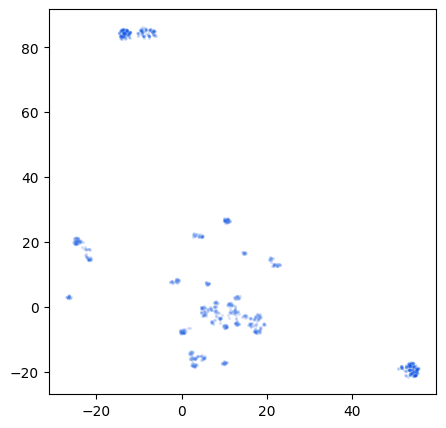

In [11]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
df_umap = apply(model,df,param)
model["graphics"]

## Stage 5 - save the model

In [ ]:
# save model to name in expected convention "<algo_name>_<model_name>"
def save(model,name):
#    with open(MODEL_DIRECTORY + name + ".json", 'w') as file:
#        json.dump(model, file)
    return model

## Stage 6 - load the model

In [ ]:
# load model from name in expected convention "<algo_name>_<model_name>"
def load(name):
#    model = {}
#    with open(MODEL_DIRECTORY + name + ".json", 'r') as file:
#        model = json.load(file)
    return model

## Stage 7 - provide a summary of the model

In [ ]:
# return a model summary
def summary(model=None):
    returns = {"version": {"numpy": np.__version__, "pandas": pd.__version__}}
    return returns

## End of Stages
All subsequent cells are not tagged and can be used for further freeform code

In [ ]:
summary(model)